In [1]:
import pandas as pd
from oversampling_binary import split_dataset, apply_smote, train_random_forest, rf_plot_confusion_matrices, train_svm, svm_plot_confusion_matrices, lightgbm_plot_confusion_matrices, train_lightgbm


# CLASIFICAZIONE BINARIA

In [2]:
# Caricare il dataset e applicare lo split
csv_file_path = 'C:/underwater-classification/features_extraction/audio_features.csv'

In [3]:
# Carica il file CSV in un DataFrame
df = pd.read_csv(csv_file_path)

In [4]:
df

,File Name,Class,Subclass,Spectral Centroid Mean,Spectral Bandwidth RMS,Standard Deviation,Skewness,Kurtosis,Shannon Entropy,Renyi Entropy,Rate of Attack,Rate of Decay,Threshold Crossings,Silence Ratio,Mean,Max Over Mean,Min Over Mean,Energy Measurements
0,0f9867d8-fcf7-40d1-b846-3f7fb8100eb7_seg1.wav,Non-Target,Ambient Noise,2585.774150,3545.441382,0.226857,0.290663,0.892096,4.972139,-5.535674,376.987654,0.003933,4596,0.611758,-0.034153,-21.482748,23.621908,0.052631
1,0f9867d8-fcf7-40d1-b846-3f7fb8100eb7_seg2.wav,Non-Target,Ambient Noise,3004.490961,3774.635411,0.108625,-0.005662,-0.569438,5.162510,-6.898534,388.414286,0.003898,4892,0.634714,-0.032923,-9.492707,10.171222,0.012883
2,0f9867d8-fcf7-40d1-b846-3f7fb8100eb7_seg3.wav,Non-Target,Ambient Noise,2374.518939,3489.082003,0.247894,-0.276421,0.685544,4.945729,-5.216699,354.935065,0.003911,2814,0.576922,-0.030692,-25.133602,32.582104,0.062393
3,0f9867d8-fcf7-40d1-b846-3f7fb8100eb7_seg4.wav,Non-Target,Ambient Noise,2821.144296,3698.989681,0.156887,0.579543,1.394184,4.977810,-6.245069,351.652174,0.003900,3842,0.676630,-0.033124,-17.890182,14.250049,0.025711
4,0f9867d8-fcf7-40d1-b846-3f7fb8100eb7_seg5.wav,Non-Target,Ambient Noise,2649.515257,3629.187032,0.182234,-0.088010,-0.083039,5.108433,-5.868417,360.301370,0.003938,4086,0.587979,-0.031081,-16.133920,20.697605,0.034175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50988,ship_small_seg5.wav,Target,Vessel,456.747011,797.837269,0.194804,0.013841,0.040806,4.912163,-5.505589,374.087500,0.004186,3257,0.502427,0.010898,67.170630,-71.718500,0.038067
50989,ship_small_seg6.wav,Target,Vessel,452.009912,804.062723,0.187102,0.015867,0.072808,4.923598,-5.597314,374.125000,0.004034,3284,0.499966,0.010380,68.853870,-69.641780,0.035115
50990,ship_small_seg7.wav,Target,Vessel,446.388360,808.959976,0.179071,0.000758,0.094906,4.904681,-5.670921,374.100000,0.003832,3247,0.500477,0.011149,60.261180,-65.437140,0.032191
50991,ship_small_seg8.wav,Target,Vessel,451.316540,794.817133,0.188441,-0.002943,0.136695,4.846811,-5.513616,374.087500,0.004043,3283,0.495841,0.010464,76.876610,-72.440750,0.035620


In [5]:
print("Distribuzione delle Classi prima dello split:")
print(df['Class'].value_counts())

Distribuzione delle Classi prima dello split:
Class
Target        43181
Non-Target     7812
Name: count, dtype: int64


In [6]:
df_Target = df[df['Class'] == 'Target']

print("Distribuzione delle subclass in Target prima dello split:")
print(df_Target['Subclass'].value_counts())

Distribuzione delle subclass in Target prima dello split:
Subclass
Passengership                       11728
Tanker                              11221
Tug                                 10162
Cargo                                9671
Vessel                                307
Sonar                                  20
Seismic airguns surveys                18
Seal bomb                              17
Echosounder                            14
Underwater Communication Signals        6
Scuba divers                            4
Seafloor fossil fuel processing         4
Acoustic release                        3
Acoustic Harassment Devices             2
Explosion                               2
Fishing pinger                          2
Name: count, dtype: int64


In [7]:
df_NonTarget = df[df['Class'] == 'Non-Target']

print("Distribuzione delle subclass in Non-Target prima dello split:")
print(df_NonTarget['Subclass'].value_counts())

Distribuzione delle subclass in Non-Target prima dello split:
Subclass
Humpback Whale                1523
Sperm Whale                   1107
Fin, Finback Whale             803
Pygmy Blue Whale               493
Blue whale                     280
                              ... 
Ringed Seal                      2
Australian Snubfin Dolphin       1
True_s beaked whale              1
Harbor porpoise                  1
Pygmy Right Whale                1
Name: count, Length: 96, dtype: int64


### Filtro dataframe

In [8]:
df['File Name'] = df['File Name'].str[:-4]
# Aggiungi una colonna "Parent" che contiene il prefisso del file per mantenere i segmenti coesi
df['Parent'] = df['File Name'].str.extract(r'^(.*?)(?=_seg)')

# Filtra subclass con almeno 10 parent distinti
parent_counts = df.groupby('Subclass')['Parent'].nunique()
subclasses_to_keep = parent_counts[parent_counts >= 10].index
df = df[df['Subclass'].isin(subclasses_to_keep)].copy()

print(f"Dimensione totale dopo il filtraggio: {df.shape[0]} campioni")

Dimensione totale dopo il filtraggio: 49429 campioni


## SPLIT

Distribuzione delle subclass nel set di addestramento:
Class
Target 33872 ok
Non-Target 4917 ok
     
Distribuzione delle subclass nel set di validazione:
Class
Target 4403 -> 4394 ha 9 campioni in più
Non-Target 613 -> 528 ha 85 campioni in più

Distribuzione delle subclass nel set di test: 
Class
Target 4814 -> 4823 ha 9 campioni in meno
Non-Target 810 -> 895 ha 85 campioni in meno

In [9]:
X_train_imputed, X_val_imputed, X_test_imputed, y_train, y_val, y_test = split_dataset(df)


Dimensione del set di addestramento: 38789 campioni (78.47%)
Dimensione del set di validazione: 5016 campioni (10.15%)
Dimensione del set di test: 5624 campioni (11.38%)

Distribuzione delle subclass nel set di addestramento:
Class
Target        33872
Non-Target     4917
Name: count, dtype: int64

Distribuzione delle subclass nel set di validazione:
Class
Target        4403
Non-Target     613
Name: count, dtype: int64

Distribuzione delle subclass nel set di test:
Class
Target        4814
Non-Target     810
Name: count, dtype: int64


In [10]:
X_train_imputed[['File Name', 'Parent', 'Class']].groupby(['Parent', 'File Name']).describe()

Class  \
                                                                                count   
Parent                               File Name                                          
1cc5583b-fe72-4cb2-b64c-563bd87ad91b 1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg1      1   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg10     1   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg11     1   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg12     1   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg13     1   
...                                                                               ...   
ship_small                           ship_small_seg5                                1   
                                     ship_small_seg6                                1   
                                     ship_small_seg7                                1   
                                     ship_small_seg8                                1   
                                     ship_small_seg9                                1   

                                                                                        \
                                                                                unique   
Parent                               File Name                                           
1cc5583b-fe72-4cb2-b64c-563bd87ad91b 1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg1       1   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg10      1   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg11      1   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg12      1   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg13      1   
...                                                                                ...   
ship_small                           ship_small_seg5                                 1   
                                     ship_small_seg6                                 1   
                                     ship_small_seg7                                 1   
                                     ship_small_seg8                                 1   
                                     ship_small_seg9                                 1   

                                                                                         \
                                                                                    top   
Parent                               File Name                                            
1cc5583b-fe72-4cb2-b64c-563bd87ad91b 1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg1   Target   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg10  Target   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg11  Target   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg12  Target   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg13  Target   
...                                                                                 ...   
ship_small                           ship_small_seg5                             Target   
                                     ship_small_seg6                             Target   
                                     ship_small_seg7                             Target   
                                     ship_small_seg8                             Target   
                                     ship_small_seg9                             Target   

                                                                                      
                                                                                freq  
Parent                               File Name                                        
1cc5583b-fe72-4cb2-b64c-563bd87ad91b

In [11]:
X_val_imputed[['File Name', 'Parent', 'Class']].groupby(['Parent', 'File Name']).describe()

Class  \
                                                                                                    count   
Parent                                           File Name                                                  
20160531-7_142749                                20160531-7_142749_seg1                                 1   
                                                 20160531-7_142749_seg10                                1   
                                                 20160531-7_142749_seg100                               1   
                                                 20160531-7_142749_seg101                               1   
                                                 20160531-7_142749_seg102                               1   
...                                                                                                   ...   
Striped-Dolphin-Whistles-PAM_20160206_015539_377 Striped-Dolphin-Whistles-PAM_20160206_015539_37...     1   
                                                 Striped-Dolphin-Whistles-PAM_20160206_015539_37...     1   
                                                 Striped-Dolphin-Whistles-PAM_20160206_015539_37...     1   
                                                 Striped-Dolphin-Whistles-PAM_20160206_015539_37...     1   
                                                 Striped-Dolphin-Whistles-PAM_20160206_015539_37...     1   

                                                                                                            \
                                                                                                    unique   
Parent                                           File Name                                                   
20160531-7_142749                                20160531-7_142749_seg1                                  1   
                                                 20160531-7_142749_seg10                                 1   
                                                 20160531-7_142749_seg100                                1   
                                                 20160531-7_142749_seg101                                1   
                                                 20160531-7_142749_seg102                                1   
...                                                                                                    ...   
Striped-Dolphin-Whistles-PAM_20160206_015539_377 Striped-Dolphin-Whistles-PAM_20160206_015539_37...      1   
                                                 Striped-Dolphin-Whistles-PAM_20160206_015539_37...      1   
                                                 Striped-Dolphin-Whistles-PAM_20160206_015539_37...      1   
                                                 Striped-Dolphin-Whistles-PAM_20160206_015539_37...      1   
                                                 Striped-Dolphin-Whistles-PAM_20160206_015539_37...      1   

                                                                                                                 \
                                                                                                            top   
Parent                                           File Name                                                        
20160531-7_142749                                20160531-7_142749_seg1                                  Target   
                                                 20160531-7_142749_seg10                                 Target   
                                                 20160531-7_142749_seg100                                Target   
                                                 20160531-7_142749_seg101                                Target   
                                                 20160531-7_142749_seg102                                Target   
...                                                                                                         ... 

In [12]:
X_test_imputed[['File Name', 'Parent', 'Class']].groupby(['Parent', 'File Name']).describe()

Class  \
                                                                               count   
Parent                               File Name                                         
20160516a-9_9                        20160516a-9_9_seg1                            1   
                                     20160516a-9_9_seg2                            1   
                                     20160516a-9_9_seg3                            1   
20160616b-21_200904                  20160616b-21_200904_seg1                      1   
                                     20160616b-21_200904_seg10                     1   
...                                                                              ...   
e60488c2-30fb-414b-bc9f-ee16f886a897 e60488c2-30fb-414b-bc9f-ee16f886a897_seg5     1   
                                     e60488c2-30fb-414b-bc9f-ee16f886a897_seg6     1   
                                     e60488c2-30fb-414b-bc9f-ee16f886a897_seg7     1   
                                     e60488c2-30fb-414b-bc9f-ee16f886a897_seg8     1   
                                     e60488c2-30fb-414b-bc9f-ee16f886a897_seg9     1   

                                                                                       \
                                                                               unique   
Parent                               File Name                                          
20160516a-9_9                        20160516a-9_9_seg1                             1   
                                     20160516a-9_9_seg2                             1   
                                     20160516a-9_9_seg3                             1   
20160616b-21_200904                  20160616b-21_200904_seg1                       1   
                                     20160616b-21_200904_seg10                      1   
...                                                                               ...   
e60488c2-30fb-414b-bc9f-ee16f886a897 e60488c2-30fb-414b-bc9f-ee16f886a897_seg5      1   
                                     e60488c2-30fb-414b-bc9f-ee16f886a897_seg6      1   
                                     e60488c2-30fb-414b-bc9f-ee16f886a897_seg7      1   
                                     e60488c2-30fb-414b-bc9f-ee16f886a897_seg8      1   
                                     e60488c2-30fb-414b-bc9f-ee16f886a897_seg9      1   

                                                                                            \
                                                                                       top   
Parent                               File Name                                               
20160516a-9_9                        20160516a-9_9_seg1                             Target   
                                     20160516a-9_9_seg2                             Target   
                                     20160516a-9_9_seg3                             Target   
20160616b-21_200904                  20160616b-21_200904_seg1                       Target   
                                     20160616b-21_200904_seg10                      Target   
...                                                                                    ...   
e60488c2-30fb-414b-bc9f-ee16f886a897 e60488c2-30fb-414b-bc9f-ee16f886a897_seg5  Non-Target   
                                     e60488c2-30fb-414b-bc9f-ee16f886a897_seg6  Non-Target   
                                     e60488c2-30fb-414b-bc9f-ee16f886a897_seg7  Non-Target   
                                     e60488c2-30fb-414b-bc9f-ee16f886a897_seg8  Non-Target   
                                     e60488c2-30fb-414b-bc9f-ee16f886a897_seg9  Non-Target   

                                                                                     
                                                                               freq  
Parent                               File Name                                       
20160516a-9_9           

## SMOTE

In [13]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"  # Adatta questo valore al numero di core che desideri utilizzare

In [14]:
X_train_resampled, y_train_resampled = apply_smote(X_train_imputed, y_train, 1)


Distribuzione delle subclass DOPO il primo livello di SMOTE:
Subclass
Killer Whale                          1163
Minke Whale                           1163
Odontocete                            1163
Melon Headed Whale                    1163
Fraser_s Dolphin                      1163
Rough-Toothed Dolphin                 1163
Clymene Dolphin                       1163
Southern Right Whale                  1163
Bowhead Whale                         1163
Spinner Dolphin                       1163
Narwhal                               1163
Harp Seal                             1163
Leopard Seal                          1163
Bearded Seal                          1163
Walrus                                1163
Ross Seal                             1163
Pantropical Spotted Dolphin           1163
Long-Finned Pilot Whale               1163
Sperm Whale                           1163
Beluga, White Whale                   1163
White-sided Dolphin                   1163
Atlantic Spotted Dolphin  

In [15]:
# Stampare le forme dei dataset
print("\nForme dei dataset:")
print(f"Train: {X_train_imputed.shape}") #validation
print(f"Validation: {X_val_imputed.shape}") #validation
print(f"Test: {X_test_imputed.shape}") #test
print(f"Train bilanciato e filtrato: {X_train_resampled.shape}") #train dopo SMOTE


Forme dei dataset:
Train: (38789, 19)
Validation: (5016, 19)
Test: (5624, 19)
Train bilanciato e filtrato: (88300, 15)


# Esperimento 1

Esperimento effettuato prendendo come riferimento alcune features numeriche da "Malfante et al."

In [16]:
# Rimuovi le colonne non necessarie per evitare errori nei nomi delle feature
X_val_imputed = X_val_imputed.drop(columns=["Class", "File Name", "Parent", "Subclass"], errors='ignore')
X_test_imputed = X_test_imputed.drop(columns=["Class", "File Name", "Parent", "Subclass"], errors='ignore')

### 1.1 Random Forest Model

In [17]:
random_forest_model = train_random_forest(X_train_resampled, y_train_resampled, X_val_imputed, y_val, X_test_imputed, y_test)

Accuratezza sul Validation Set: 0.9926
Log Loss sul Validation Set: 0.0302

=== Report di Classificazione - Validation Set ===
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       613
           1       1.00      0.99      1.00      4403

    accuracy                           0.99      5016
   macro avg       0.97      0.99      0.98      5016
weighted avg       0.99      0.99      0.99      5016

Accuratezza sul Test Set: 0.9897
Log Loss sul Test Set: 0.0341

=== Report di Classificazione - Test Set ===
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       810
           1       0.99      0.99      0.99      4814

    accuracy                           0.99      5624
   macro avg       0.98      0.98      0.98      5624
weighted avg       0.99      0.99      0.99      5624



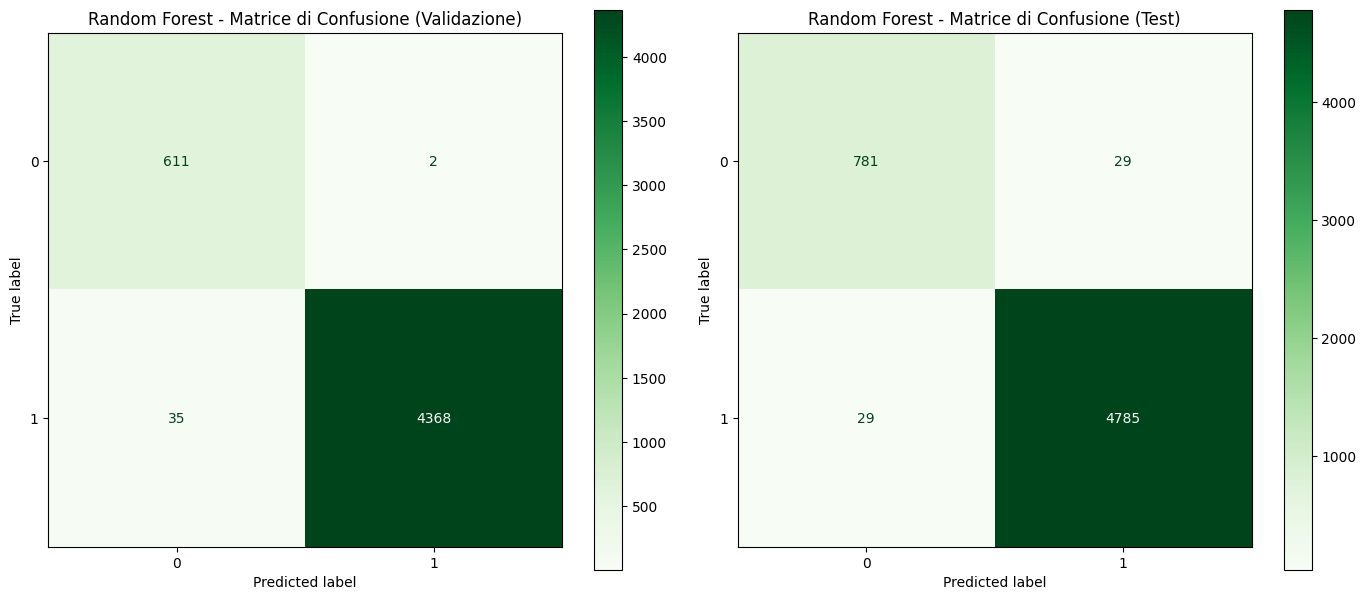

In [18]:
rf_plot_confusion_matrices(random_forest_model, X_val_imputed, y_val, X_test_imputed, y_test)

### 1.2 SVM Model

In [19]:
svm_model = train_svm(X_train_resampled, y_train_resampled, X_val_imputed, y_val, X_test_imputed, y_test)

Distribuzione delle classi reali nel set di validazione: [ 613 4403]
Distribuzione delle classi predette nel set di validazione: [ 389 4627]
Report di classificazione del set di validazione:
              precision    recall  f1-score   support

           0       0.73      0.46      0.57       613
           1       0.93      0.98      0.95      4403

    accuracy                           0.91      5016
   macro avg       0.83      0.72      0.76      5016
weighted avg       0.90      0.91      0.90      5016

Accuratezza sul set di validazione: 0.9135
Distribuzione delle classi reali nel set di test: [ 810 4814]
Distribuzione delle classi predette nel set di test: [ 815 4809]
Report di classificazione del set di test:
              precision    recall  f1-score   support

           0       0.75      0.76      0.76       810
           1       0.96      0.96      0.96      4814

    accuracy                           0.93      5624
   macro avg       0.86      0.86      0.86      56

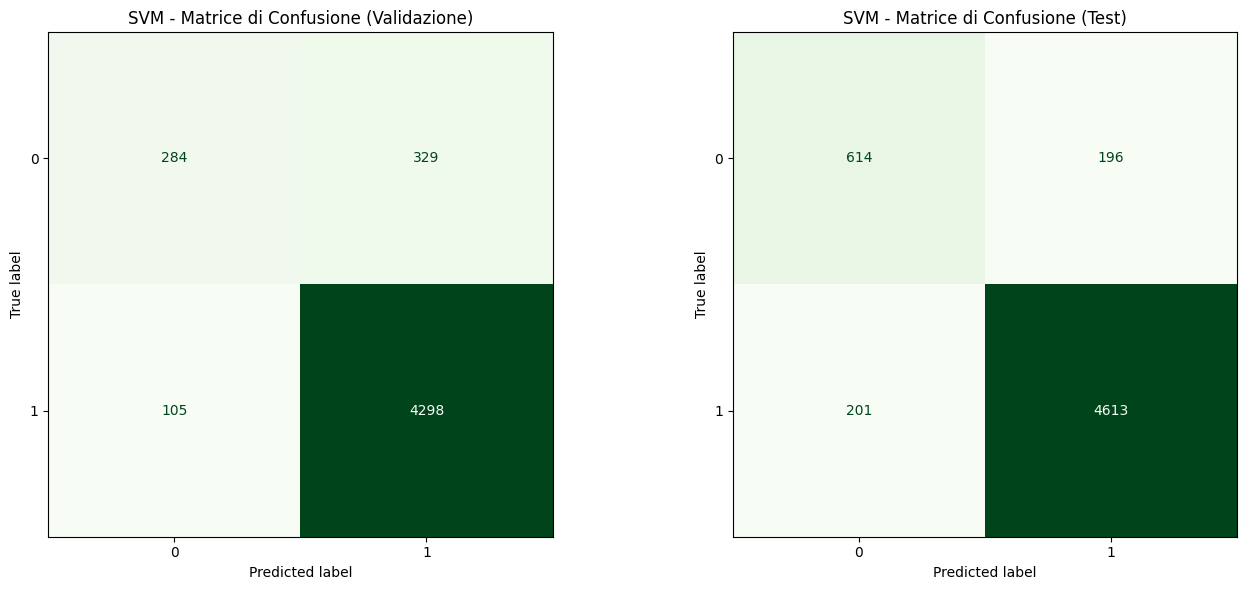

In [20]:
svm_plot_confusion_matrices(svm_model, X_val_imputed, y_val, X_test_imputed, y_test)

### 1.3 LightGBM Model

In [21]:
lightgbm_model = train_lightgbm(X_train_resampled, y_train_resampled, X_val_imputed, y_val, X_test_imputed, y_test)

Dimensioni dopo NaN nel set di addestramento: X_train: (88300, 15), y_train: (88300,)
Dimensioni dopo NaN nel set di validazione: X_val: (5016, 15), y_val: (5016,)
Dimensioni dopo NaN nel set di test: X_test: (5624, 15), y_test: (5624,)
Classi nel set di addestramento: [0 1]
Classi nel set di validazione: [0 1]
Classi nel set di test: [0 1]
Report di classificazione del set di validazione:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       613
           1       1.00      0.99      1.00      4403

    accuracy                           0.99      5016
   macro avg       0.97      0.99      0.98      5016
weighted avg       0.99      0.99      0.99      5016

Accuratezza sul set di validazione: 0.9928
Report di classificazione del set di test:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       810
           1       0.99      1.00      1.00      4814

    accuracy                  

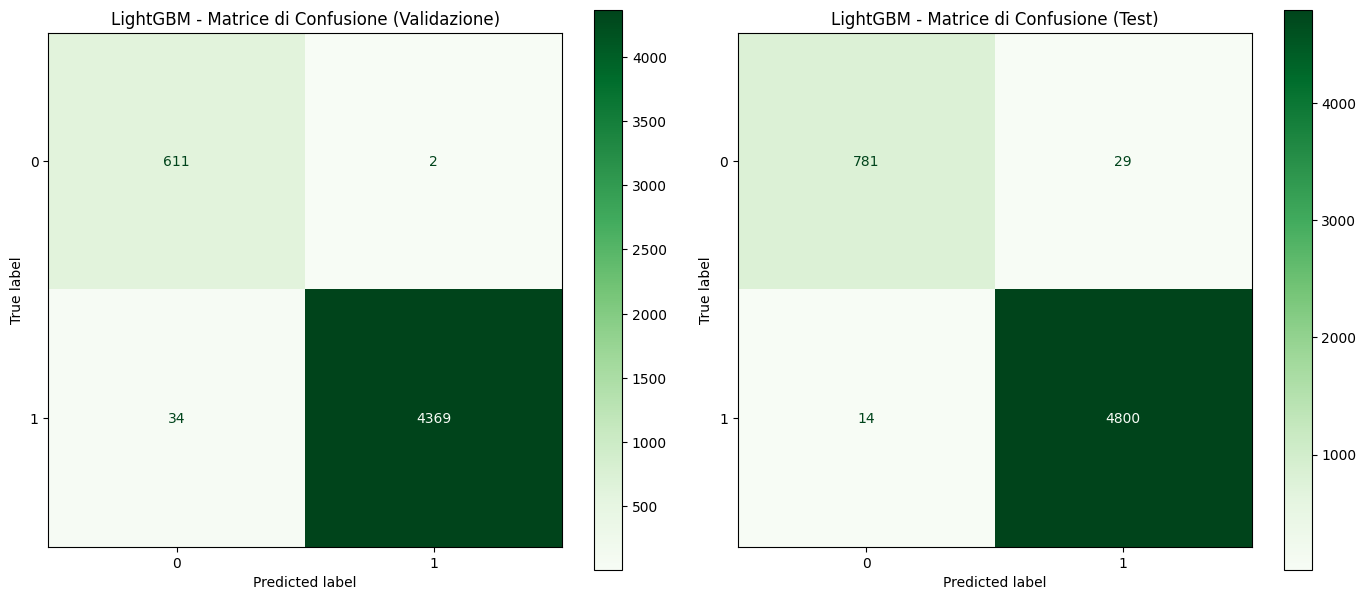

In [22]:
lightgbm_plot_confusion_matrices(lightgbm_model, X_val_imputed, y_val, X_test_imputed, y_test)

## Esperimento 2

Esperimento effettuato prendendo come riferimento alcune features numeriche da “BirdNet”

In [23]:
csv_file_path_exp1 = 'C:/underwater-classification/features_extraction/exp1_audio_features.csv'
df_exp1 = pd.read_csv(csv_file_path_exp1)

In [24]:
df_exp1['File Name'] = df_exp1['File Name'].str[:-4]
# Aggiungi una colonna "Parent" che contiene il prefisso del file per mantenere i segmenti coesi
df_exp1['Parent'] = df_exp1['File Name'].str.extract(r'^(.*?)(?=_seg)')

# Filtra subclass con almeno 10 parent distinti
parent_counts = df_exp1.groupby('Subclass')['Parent'].nunique()
subclasses_to_keep = parent_counts[parent_counts >= 10].index
df_exp1 = df_exp1[df_exp1['Subclass'].isin(subclasses_to_keep)].copy()

print(f"Dimensione totale dopo il filtraggio: {df_exp1.shape[0]} campioni")

Dimensione totale dopo il filtraggio: 49429 campioni


In [25]:
X_train_imputed_exp1, X_val_imputed_exp1, X_test_imputed_exp1, y_train_encoded_exp1, y_val_encoded_exp1, y_test_encoded_exp1 = split_dataset(df_exp1)


Dimensione del set di addestramento: 38789 campioni (78.47%)
Dimensione del set di validazione: 5016 campioni (10.15%)
Dimensione del set di test: 5624 campioni (11.38%)

Distribuzione delle subclass nel set di addestramento:
Class
Target        33872
Non-Target     4917
Name: count, dtype: int64

Distribuzione delle subclass nel set di validazione:
Class
Target        4403
Non-Target     613
Name: count, dtype: int64

Distribuzione delle subclass nel set di test:
Class
Target        4814
Non-Target     810
Name: count, dtype: int64


In [26]:

X_train_resampled_exp1, y_train_resampled_exp1 = apply_smote(X_train_imputed_exp1, y_train_encoded_exp1, 1)


Distribuzione delle subclass DOPO il primo livello di SMOTE:
Subclass
Killer Whale                          1163
Minke Whale                           1163
Odontocete                            1163
Melon Headed Whale                    1163
Fraser_s Dolphin                      1163
Rough-Toothed Dolphin                 1163
Clymene Dolphin                       1163
Southern Right Whale                  1163
Bowhead Whale                         1163
Spinner Dolphin                       1163
Narwhal                               1163
Harp Seal                             1163
Leopard Seal                          1163
Bearded Seal                          1163
Walrus                                1163
Ross Seal                             1163
Pantropical Spotted Dolphin           1163
Long-Finned Pilot Whale               1163
Sperm Whale                           1163
Beluga, White Whale                   1163
White-sided Dolphin                   1163
Atlantic Spotted Dolphin  

In [27]:
# Rimuovi le colonne non necessarie per evitare errori nei nomi delle feature
X_val_imputed_exp1 = X_val_imputed_exp1.drop(columns=["Class", "File Name", "Parent", "Subclass"], errors='ignore')
X_test_imputed_exp1 = X_test_imputed_exp1.drop(columns=["Class", "File Name", "Parent", "Subclass"], errors='ignore')

### 2.1 Random Forest Model

In [28]:
random_forest_model_exp1 = train_random_forest(X_train_resampled_exp1, y_train_resampled_exp1, X_val_imputed_exp1, y_val_encoded_exp1, X_test_imputed_exp1, y_test_encoded_exp1)

Accuratezza sul Validation Set: 0.9908
Log Loss sul Validation Set: 0.0346

=== Report di Classificazione - Validation Set ===
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       613
           1       1.00      0.99      0.99      4403

    accuracy                           0.99      5016
   macro avg       0.97      0.99      0.98      5016
weighted avg       0.99      0.99      0.99      5016

Accuratezza sul Test Set: 0.9908
Log Loss sul Test Set: 0.0394

=== Report di Classificazione - Test Set ===
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       810
           1       1.00      0.99      0.99      4814

    accuracy                           0.99      5624
   macro avg       0.98      0.98      0.98      5624
weighted avg       0.99      0.99      0.99      5624



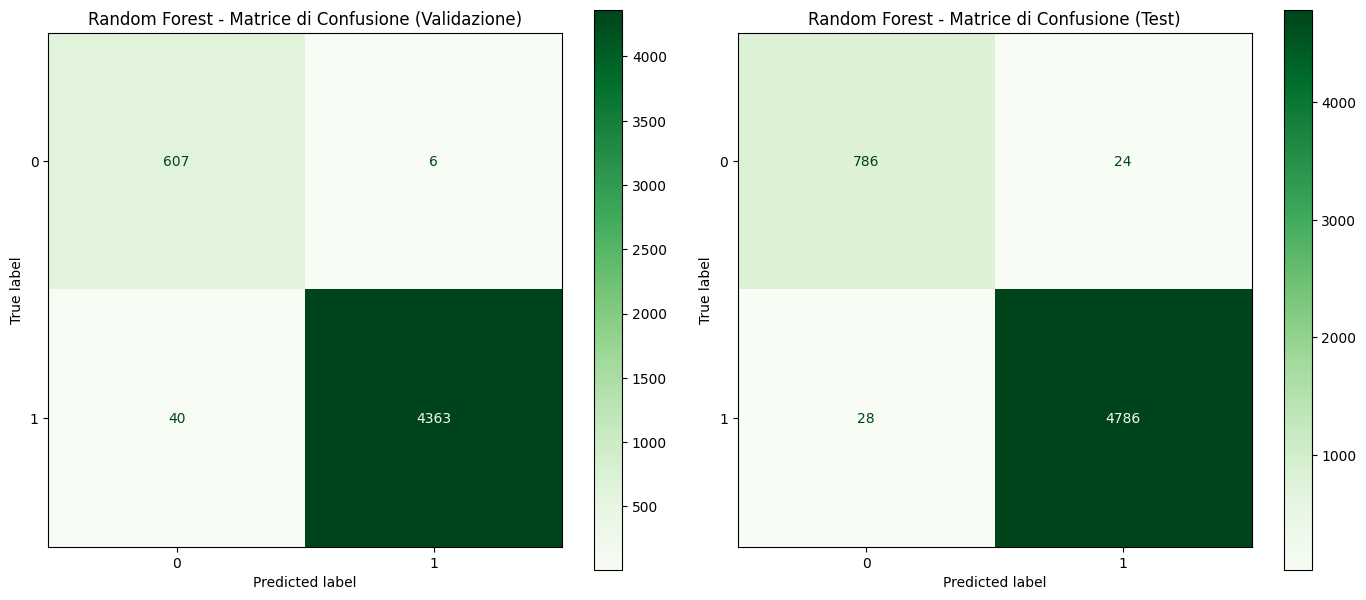

In [29]:
rf_plot_confusion_matrices(random_forest_model_exp1, X_val_imputed_exp1, y_val_encoded_exp1, X_test_imputed_exp1, y_test_encoded_exp1)


### 2.2 SVM Model

In [30]:
svm_model_exp1 = train_svm(X_train_resampled_exp1, y_train_resampled_exp1, X_val_imputed_exp1, y_val_encoded_exp1, X_test_imputed_exp1, y_test_encoded_exp1)

Distribuzione delle classi reali nel set di validazione: [ 613 4403]
Distribuzione delle classi predette nel set di validazione: [ 607 4409]
Report di classificazione del set di validazione:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       613
           1       0.99      0.99      0.99      4403

    accuracy                           0.98      5016
   macro avg       0.96      0.95      0.95      5016
weighted avg       0.98      0.98      0.98      5016

Accuratezza sul set di validazione: 0.9805
Distribuzione delle classi reali nel set di test: [ 810 4814]
Distribuzione delle classi predette nel set di test: [ 854 4770]
Report di classificazione del set di test:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       810
           1       0.99      0.98      0.98      4814

    accuracy                           0.97      5624
   macro avg       0.94      0.96      0.95      56

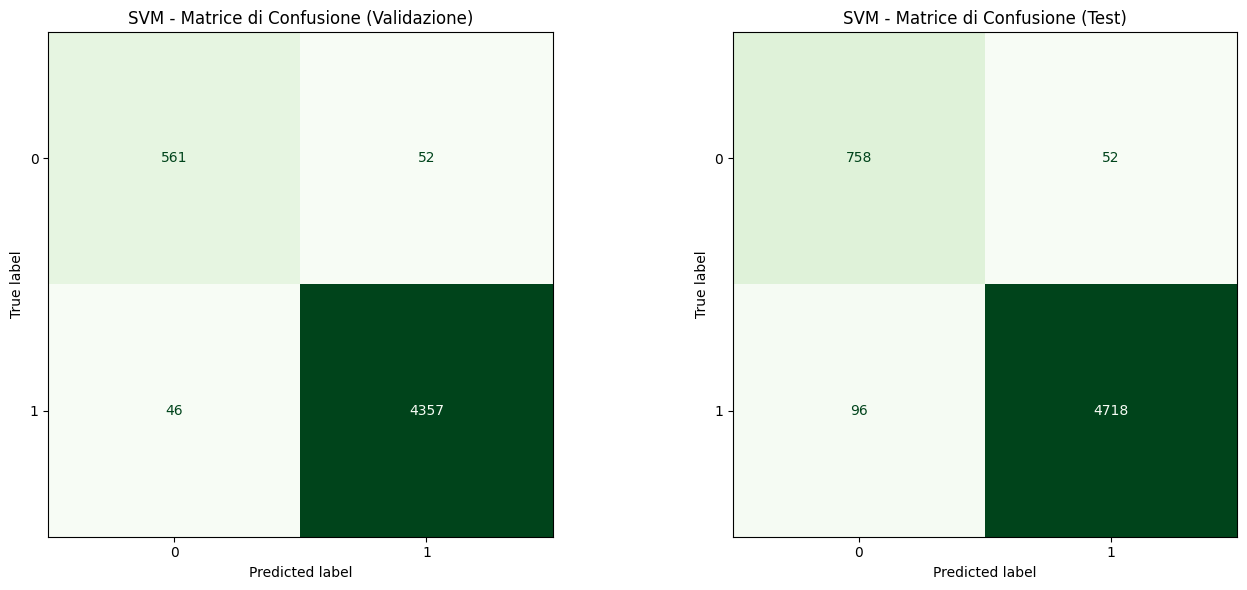

In [31]:
svm_plot_confusion_matrices(svm_model_exp1, X_val_imputed_exp1, y_val_encoded_exp1, X_test_imputed_exp1, y_test_encoded_exp1)

### 2.3 LightGBM Model

In [32]:
lightgbm_model_exp1 = train_lightgbm(X_train_resampled_exp1, y_train_resampled_exp1, X_val_imputed_exp1, y_val_encoded_exp1, X_test_imputed_exp1, y_test_encoded_exp1)

Dimensioni dopo NaN nel set di addestramento: X_train: (88300, 28), y_train: (88300,)
Dimensioni dopo NaN nel set di validazione: X_val: (5016, 28), y_val: (5016,)
Dimensioni dopo NaN nel set di test: X_test: (5624, 28), y_test: (5624,)
Classi nel set di addestramento: [0 1]
Classi nel set di validazione: [0 1]
Classi nel set di test: [0 1]
Report di classificazione del set di validazione:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       613
           1       1.00      0.99      1.00      4403

    accuracy                           0.99      5016
   macro avg       0.98      0.99      0.99      5016
weighted avg       0.99      0.99      0.99      5016

Accuratezza sul set di validazione: 0.9942
Report di classificazione del set di test:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       810
           1       0.99      1.00      1.00      4814

    accuracy                  

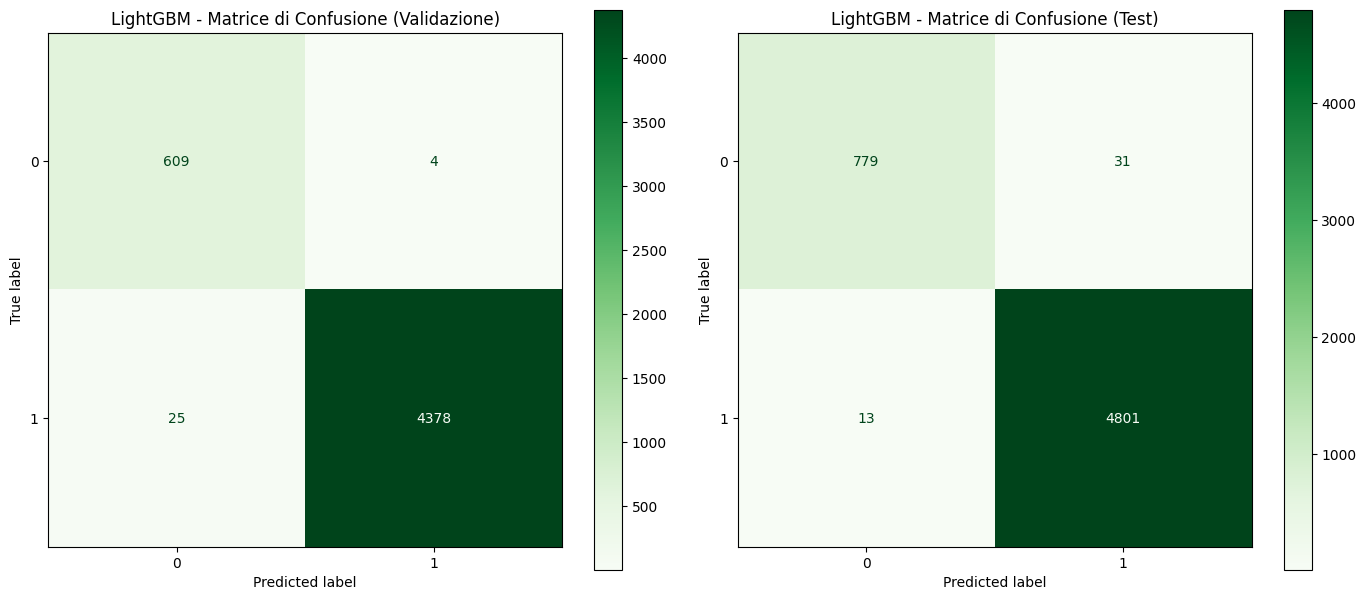

In [33]:
lightgbm_plot_confusion_matrices(lightgbm_model_exp1, X_val_imputed_exp1, y_val_encoded_exp1, X_test_imputed_exp1, y_test_encoded_exp1)

## Esperimento 3

Esperimento effettuato prendendo come riferimento features numeriche da "A Survey on Audio Feature Extraction for Automatic Music Genre Classification" di Dhamodaran et al.

In [34]:
csv_file_path_exp2 = 'C:/underwater-classification/features_extraction/exp2_audio_features.csv'
df_exp2 = pd.read_csv(csv_file_path_exp2)

In [35]:
df_exp2['File Name'] = df_exp2['File Name'].str[:-4]
# Aggiungi una colonna "Parent" che contiene il prefisso del file per mantenere i segmenti coesi
df_exp2['Parent'] = df_exp2['File Name'].str.extract(r'^(.*?)(?=_seg)')

# Filtra subclass con almeno 10 parent distinti
parent_counts = df_exp2.groupby('Subclass')['Parent'].nunique()
subclasses_to_keep = parent_counts[parent_counts >= 10].index
df_exp2 = df_exp2[df_exp2['Subclass'].isin(subclasses_to_keep)].copy()

print(f"Dimensione totale dopo il filtraggio: {df_exp2.shape[0]} campioni")

Dimensione totale dopo il filtraggio: 49429 campioni


In [36]:
X_train_imputed_exp2, X_val_imputed_exp2, X_test_imputed_exp2, y_train_encoded_exp2, y_val_encoded_exp2, y_test_encoded_exp2 = split_dataset(df_exp2)


Dimensione del set di addestramento: 38789 campioni (78.47%)
Dimensione del set di validazione: 5016 campioni (10.15%)
Dimensione del set di test: 5624 campioni (11.38%)

Distribuzione delle subclass nel set di addestramento:
Class
Target        33872
Non-Target     4917
Name: count, dtype: int64

Distribuzione delle subclass nel set di validazione:
Class
Target        4403
Non-Target     613
Name: count, dtype: int64

Distribuzione delle subclass nel set di test:
Class
Target        4814
Non-Target     810
Name: count, dtype: int64


In [37]:

X_train_resampled_exp2, y_train_resampled_exp2 = apply_smote(X_train_imputed_exp2, y_train_encoded_exp2, 1)


Distribuzione delle subclass DOPO il primo livello di SMOTE:
Subclass
Killer Whale                          1163
Minke Whale                           1163
Odontocete                            1163
Melon Headed Whale                    1163
Fraser_s Dolphin                      1163
Rough-Toothed Dolphin                 1163
Clymene Dolphin                       1163
Southern Right Whale                  1163
Bowhead Whale                         1163
Spinner Dolphin                       1163
Narwhal                               1163
Harp Seal                             1163
Leopard Seal                          1163
Bearded Seal                          1163
Walrus                                1163
Ross Seal                             1163
Pantropical Spotted Dolphin           1163
Long-Finned Pilot Whale               1163
Sperm Whale                           1163
Beluga, White Whale                   1163
White-sided Dolphin                   1163
Atlantic Spotted Dolphin  

In [38]:
# Rimuovi le colonne non necessarie per evitare errori nei nomi delle feature
X_val_imputed_exp2 = X_val_imputed_exp2.drop(columns=["Class", "File Name", "Parent", "Subclass"], errors='ignore')
X_test_imputed_exp2 = X_test_imputed_exp2.drop(columns=["Class", "File Name", "Parent", "Subclass"], errors='ignore')

### 3.1 Random Forest Model

In [39]:
random_forest_model_exp2 = train_random_forest(X_train_resampled_exp2, y_train_resampled_exp2, X_val_imputed_exp2, y_val_encoded_exp2, X_test_imputed_exp2, y_test_encoded_exp2)

Accuratezza sul Validation Set: 0.9870
Log Loss sul Validation Set: 0.0398

=== Report di Classificazione - Validation Set ===
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       613
           1       1.00      0.99      0.99      4403

    accuracy                           0.99      5016
   macro avg       0.95      0.99      0.97      5016
weighted avg       0.99      0.99      0.99      5016

Accuratezza sul Test Set: 0.9886
Log Loss sul Test Set: 0.0457

=== Report di Classificazione - Test Set ===
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       810
           1       1.00      0.99      0.99      4814

    accuracy                           0.99      5624
   macro avg       0.97      0.98      0.98      5624
weighted avg       0.99      0.99      0.99      5624



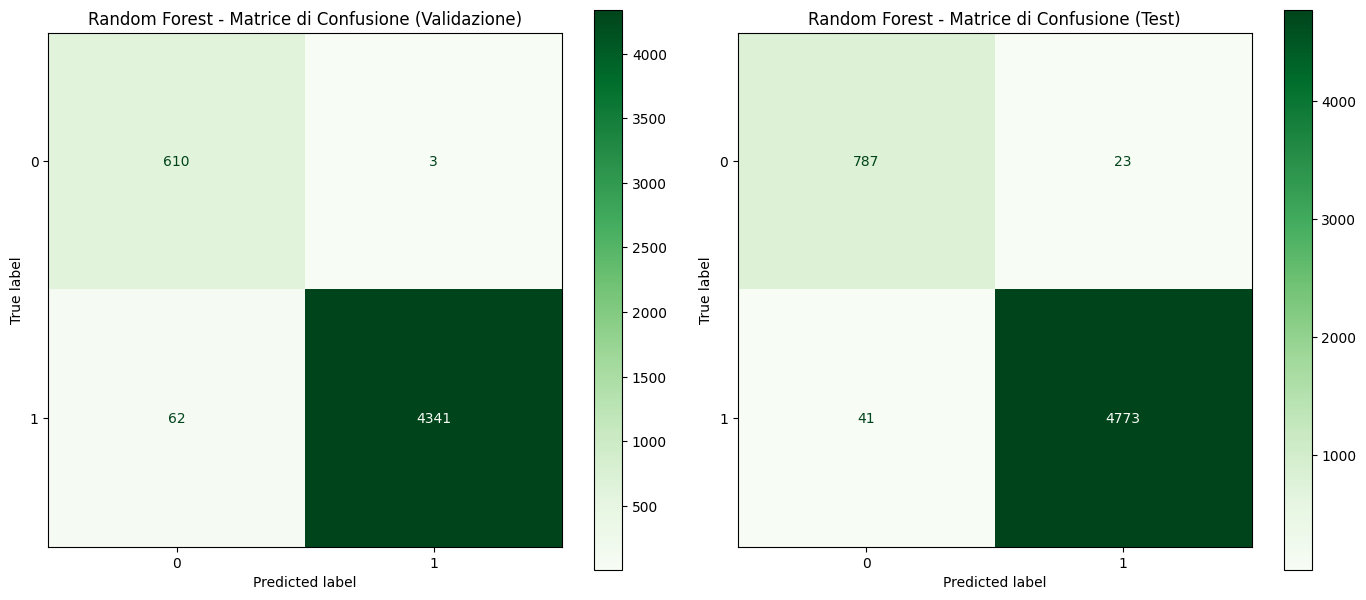

In [40]:
rf_plot_confusion_matrices(random_forest_model_exp2, X_val_imputed_exp2, y_val_encoded_exp2, X_test_imputed_exp2, y_test_encoded_exp2)

### 3.2 SVM Model 

In [41]:
svm_model_exp2 = train_svm(X_train_resampled_exp2, y_train_resampled_exp2, X_val_imputed_exp2, y_val_encoded_exp2, X_test_imputed_exp2, y_test_encoded_exp2)

Distribuzione delle classi reali nel set di validazione: [ 613 4403]
Distribuzione delle classi predette nel set di validazione: [ 648 4368]
Report di classificazione del set di validazione:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       613
           1       1.00      0.99      0.99      4403

    accuracy                           0.98      5016
   macro avg       0.95      0.98      0.97      5016
weighted avg       0.99      0.98      0.98      5016

Accuratezza sul set di validazione: 0.9846
Distribuzione delle classi reali nel set di test: [ 810 4814]
Distribuzione delle classi predette nel set di test: [ 789 4835]
Report di classificazione del set di test:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       810
           1       0.99      0.99      0.99      4814

    accuracy                           0.98      5624
   macro avg       0.97      0.96      0.96      56

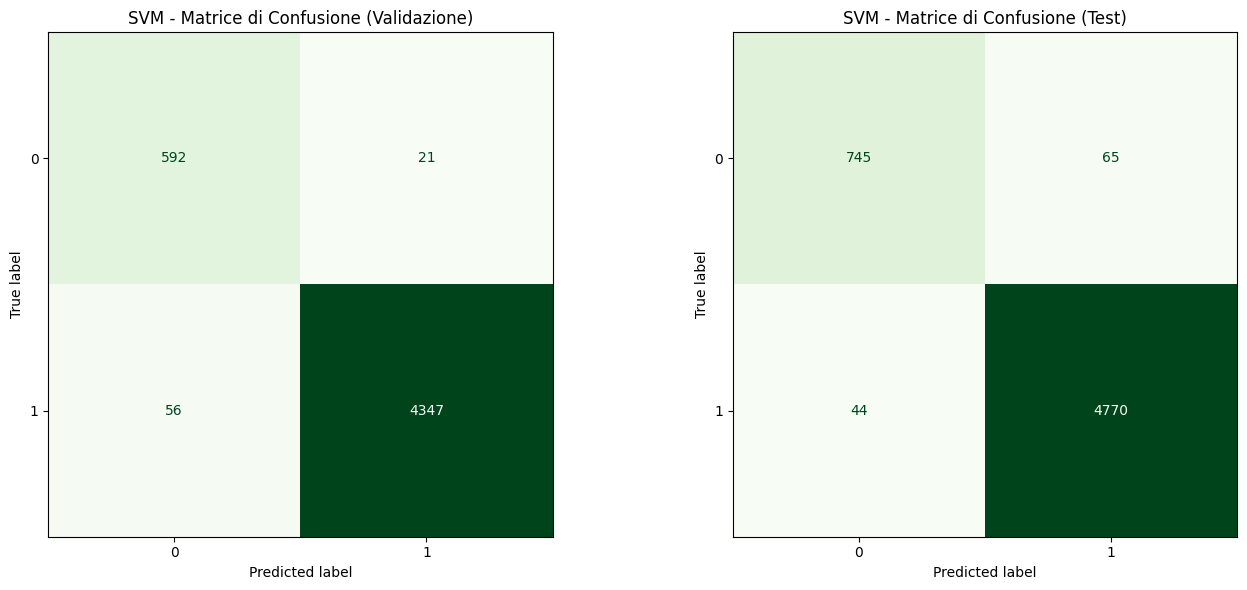

In [42]:
svm_plot_confusion_matrices(svm_model_exp2, X_val_imputed_exp2, y_val_encoded_exp2, X_test_imputed_exp2, y_test_encoded_exp2)

### 3.3 LightGBM Model

In [43]:
lightgbm_model_exp2 = train_lightgbm(X_train_resampled_exp2, y_train_resampled_exp2, X_val_imputed_exp2, y_val_encoded_exp2, X_test_imputed_exp2, y_test_encoded_exp2)

Dimensioni dopo NaN nel set di addestramento: X_train: (88300, 34), y_train: (88300,)
Dimensioni dopo NaN nel set di validazione: X_val: (5016, 34), y_val: (5016,)
Dimensioni dopo NaN nel set di test: X_test: (5624, 34), y_test: (5624,)
Classi nel set di addestramento: [0 1]
Classi nel set di validazione: [0 1]
Classi nel set di test: [0 1]
Report di classificazione del set di validazione:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       613
           1       1.00      0.99      1.00      4403

    accuracy                           0.99      5016
   macro avg       0.97      0.99      0.98      5016
weighted avg       0.99      0.99      0.99      5016

Accuratezza sul set di validazione: 0.9924
Report di classificazione del set di test:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       810
           1       1.00      1.00      1.00      4814

    accuracy                  

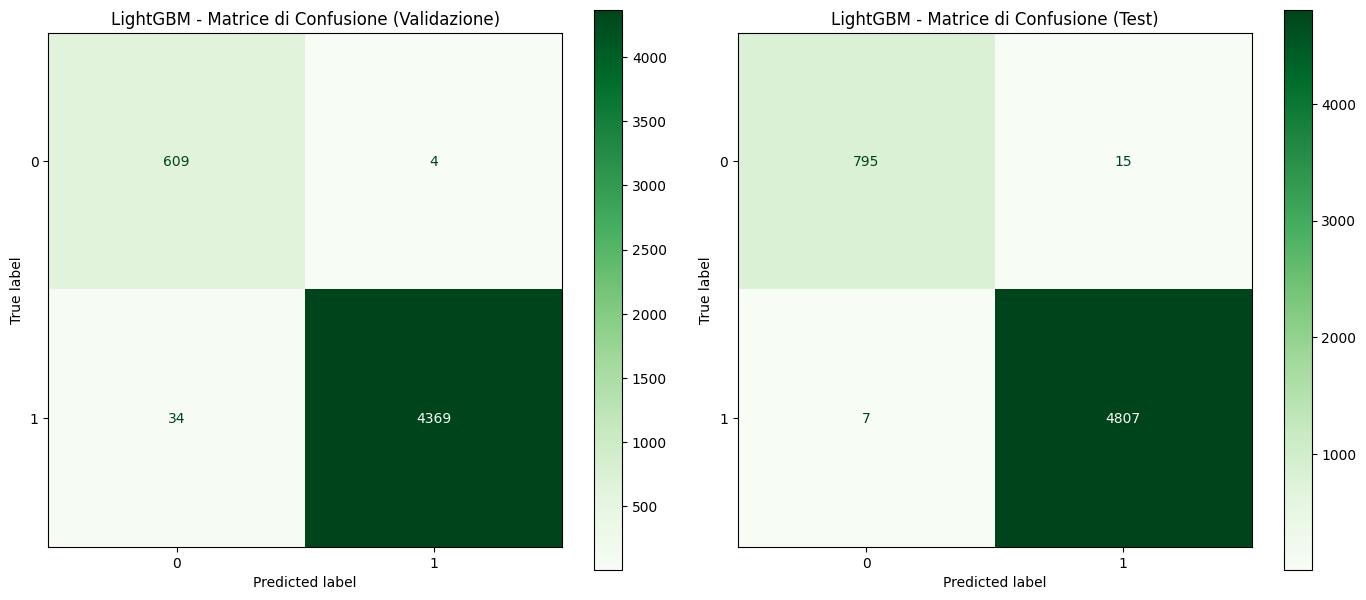

In [44]:
lightgbm_plot_confusion_matrices(lightgbm_model_exp2, X_val_imputed_exp2, y_val_encoded_exp2, X_test_imputed_exp2, y_test_encoded_exp2)